Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Weights and Bias platform login

In [ ]:
!pip install -qq wandb
import wandb

wandb.login(key='02c241f212f9509dfc9047b0520a9f402b4e4f6d')

     |████████████████████████████████| 1.8 MB 6.7 MB/s 
     |████████████████████████████████| 157 kB 63.7 MB/s 
     |████████████████████████████████| 181 kB 78.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 77.2 MB/s 
     |████████████████████████████████| 157 kB 77.9 MB/s 
     |████████████████████████████████| 157 kB 75.8 MB/s 
     |████████████████████████████████| 157 kB 70.6 MB/s 
     |████████████████████████████████| 156 kB 72.0 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import h5py
from glob import glob
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

##Reading and filtering data

###Data loading
The data is loadded from .h5 files for each object

In [ ]:
from numpy.ma.core import sqrt
columns_x = []
columns_y = []
columns_z = []
columns_t = []

for i in range(18):
    columns_x.append(f'{i}_x')
    columns_y.append(f'{i}_y')
    columns_z.append(f'{i}_z')
    columns_t.append(f'{i}_t')

experiment_columns_initial = ['Object', 'Pose', 'Experiment', 'Length', 'Accepted']

frames = []
lens = []
rejects = 0
accepts = 0

exp_df_1 = pd.DataFrame(columns=experiment_columns_initial)

print('Reading experiment data from h5 files')
for file_path in tqdm(glob('/content/drive/Othercomputers/My Laptop (1)/MSc Project/Codebase/Data/tactile_object_recognition/*.h5')):
    hf = h5py.File(file_path, 'r')
    name = list(hf.keys())[0]
    poses = list(hf[name].keys())
    for pose in poses:
        experiments = list(hf[f'{name}/{pose}'].keys())
        for experiment in experiments:
            path = f'{name}/{pose}/{experiment}'

            x_array = np.array(hf[f'{path}/tactile_data_normalized/x']).T
            y_array = np.array(hf[f'{path}/tactile_data_normalized/y']).T
            z_array = np.array(hf[f'{path}/tactile_data_normalized/z']).T
            df_x = pd.DataFrame(x_array, columns=columns_x)
            df_y = pd.DataFrame(y_array, columns=columns_y)
            df_z = pd.DataFrame(z_array, columns=columns_z)

            



            f_t_arr = np.sqrt(np.square(x_array)+np.square(y_array))
            df_t = pd.DataFrame(f_t_arr, columns=columns_t)

            result = pd.concat([df_x, df_y, df_z, df_t], axis=1, join="inner")


            result['timestamp'] = np.array(hf[f'{path}/tactile_timestamps'])
            result['change_label'] = np.array(hf[f'{path}/tactile_changes_label'])

            exp_length = (len(result)/180)
            lens.append(exp_length)
            if exp_length < 15:
                rejects = rejects + 1
                is_in = False
            else:
                is_in = True
                accepts = accepts + 1
                result['object'] = name
                result['pose'] = pose
                result['experiment'] = experiment
                frames.append(result)

            exp_df_1.loc[len(exp_df_1)] = [name, pose, experiment, exp_length, is_in]
            
    hf.close()
df = pd.concat(frames)
print(f'{accepts} experiments accepted out of {len(lens)}')

objects = df.object.unique()
weights = [28.0,165.0,24.0,210.0,16.0,78.0,125.0,227.0,127.0,62.0]

weight_df = pd.DataFrame()

weight_df['object'] = objects
weight_df['Weights'] = weights

weight_df
final_df = df.merge(weight_df, left_on='object', right_on='object')


Reading experiment data from h5 files


  0%|          | 0/10 [00:00<?, ?it/s]

426 experiments accepted out of 571


###Data cleaning
The dataset contains data from unwanted phases of the experiment. The rows from lift phase is extracted and invalid experiments are removed.

In [ ]:
count = 0
selected_count = 0
selected = []

exp_df_2 = pd.DataFrame(columns=['Object', 'Pose', 'Experiment', 'Accepted', 'Note'])

pose_count = []
count_1 = []
print('Extracting lift phase and rejecting invalid experiments...')
for object in tqdm(objects):
    object_df = final_df.loc[final_df['object'] == object]
    poses = object_df.pose.unique()
    pose_count.append(len(poses))
    #print(f'Object {object} has {len(poses)} poses')
    for pose in poses:
        pose_df = object_df[object_df['pose'] == pose]
        experiments = pose_df.experiment.unique()
        count_2 = 0
        for experiment in experiments:
            exp_df = pose_df[pose_df['experiment']==experiment].copy()
            count = count + 1
            
            #Getting rolling mean to 20
            exp_df['rolling_mean'] = exp_df['change_label'].rolling(window=20).mean()
            
            #Gettin strips of 0s on rolling mean
            idx_pairs = np.where(np.diff(np.hstack(([False],exp_df['rolling_mean'] ==0,[False]))))[0].reshape(-1,2)

            #Get length of strips
            lengths = np.diff(idx_pairs,axis=1).flatten()

            #Removing strips less that 100 samples long
            idx_pairs = idx_pairs[lengths>100]

            #Check if strips are over 10 seconds
            if((len(lengths[lengths > 1800])>0)):
                exp_df_2.loc[len(exp_df_2)] = [object, pose, experiment, False, 'Strip too long' ]
                print(object, pose, experiment, False, 'Strip too long')
                continue
            #Check if there are less than 2 long strips
            elif((len(idx_pairs)<2)):
                exp_df_2.loc[len(exp_df_2)] = [object, pose, experiment, False, 'Less than 2 strips' ]
                continue
            else:
                selected_count = selected_count + 1

                #Getting the longest 4 strips
                if(len(idx_pairs)>3):
                    longest_4 = np.flip(np.argpartition(np.diff(idx_pairs,axis=1).flatten(), -4)[-4:])
                    longest_4_idx = idx_pairs[longest_4]
                else:
                    longest_4_idx = idx_pairs

                #Arranging strips by time, earlier first
                a = longest_4_idx.tolist() 
                longest_4_idx = np.array(sorted(a, key=lambda a_entry: a_entry[0]))

                #Getting dataframe index
                longest_4_idx = longest_4_idx + exp_df.index[0]

                #Initializing lift phase column
                exp_df['lift'] = False
                
                #Getting the second strip location
                lift_start = longest_4_idx[1][0]
                lift_end = longest_4_idx[1][1]


                #Setting the lift areas to ture
                exp_df.loc[lift_start:lift_end, 'lift'] =  True
                #If small interruption during lift, add the rest of the portion too
                remark = 'Normal'
                if(len(longest_4_idx)>2):
                    next_break_length = longest_4_idx[2][0]-longest_4_idx[1][1]
                    next_break_mean = exp_df.loc[longest_4_idx[1][1]: longest_4_idx[2][0], "rolling_mean"].mean()
                    if((next_break_length<90) and (next_break_mean<0.4)):
                        lift_start = longest_4_idx[2][0]
                        lift_end = longest_4_idx[2][1]


                        exp_df.loc[lift_start:lift_end, 'lift'] =  True
                        remark = 'Appended tail'
                count_2 = count_2 + 1 
                exp_df_2.loc[len(exp_df_2)] = [object, pose, experiment, True, remark ]
                selected.append(exp_df.drop(['rolling_mean'], axis=1))
            count_1.append(count_2)  

print(f'Selected {selected_count} out of {count} experiments')

cleaned_df = pd.concat(selected)
experiments_df = cleaned_df.loc[cleaned_df['lift']].drop([ 'lift', 'timestamp', 'change_label'], axis=1).copy()
lift_only = cleaned_df.loc[cleaned_df['lift']].drop(['lift', 'timestamp', 'change_label', 'object', 'pose', 'experiment'], axis=1)

Extracting lift phase and rejecting invalid experiments...


  0%|          | 0/10 [00:00<?, ?it/s]

marbleNet Pose2 Exp6 False Strip too long
marbleNet Pose5 Exp8 False Strip too long
marbleNet Pose5 Exp9 False Strip too long
teddyBear Pose1 Exp12 False Strip too long
teddyBear Pose1 Exp13 False Strip too long
teddyBear Pose2 Exp11 False Strip too long
teddyBear Pose2 Exp13 False Strip too long
teddyBear Pose2 Exp2 False Strip too long
teddyBear Pose2 Exp8 False Strip too long
teddyBear Pose2 Exp9 False Strip too long
teddyBear Pose3 Exp5 False Strip too long
teddyBear Pose3 Exp7 False Strip too long
teddyBear Pose3 Exp8 False Strip too long
teddyBear Pose3 Exp9 False Strip too long
teddyBear Pose4 Exp1 False Strip too long
metalBox Pose3 Exp15 False Strip too long
adversarialPipe Pose3 Exp9 False Strip too long
adversarialPipe Pose4 Exp11 False Strip too long
adversarialPipe Pose4 Exp14 False Strip too long
adversarialPipe Pose4 Exp15 False Strip too long
adversarialPipe Pose4 Exp2 False Strip too long
adversarialPipe Pose4 Exp4 False Strip too long
adversarialPipe Pose4 Exp6 False 

In [ ]:
balanced_df = experiments_df.drop(experiments_df[experiments_df.Weights == 24.0].index)

In [ ]:
experiments_df

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,12_t,13_t,14_t,15_t,16_t,17_t,object,pose,experiment,Weights
1542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,-32.0,0.0,...,2.0,0.0,0.0,2.236068,1.0,2.0,SpoolSolder,Pose1,Exp1,28.0
1543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,-32.0,0.0,...,2.0,0.0,0.0,2.236068,1.0,2.0,SpoolSolder,Pose1,Exp1,28.0
1544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,-33.0,0.0,...,2.0,0.0,0.0,2.236068,1.0,2.0,SpoolSolder,Pose1,Exp1,28.0
1545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,-33.0,0.0,...,2.0,0.0,0.0,2.236068,1.0,2.0,SpoolSolder,Pose1,Exp1,28.0
1546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,-33.0,0.0,...,2.0,0.0,0.0,2.236068,1.0,2.0,SpoolSolder,Pose1,Exp1,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530979,-100.0,-39.0,-43.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,marker,Pose5,Exp4,62.0
1530980,-100.0,-39.0,-43.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,marker,Pose5,Exp4,62.0
1530981,-100.0,-39.0,-43.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,marker,Pose5,Exp4,62.0
1530982,-100.0,-39.0,-43.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,marker,Pose5,Exp4,62.0


In [ ]:
very_cleaned = experiments_df.drop_duplicates()
t_only = very_cleaned.drop(columns_x+columns_y, axis=1)
very_cleaned

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,12_t,13_t,14_t,15_t,16_t,17_t,object,pose,experiment,Weights
1542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,-32.0,0.0,...,2.0,0.0,0.0,2.236068,1.0,2.0,SpoolSolder,Pose1,Exp1,28.0
1543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,-32.0,0.0,...,2.0,0.0,0.0,2.236068,1.0,2.0,SpoolSolder,Pose1,Exp1,28.0
1544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,-33.0,0.0,...,2.0,0.0,0.0,2.236068,1.0,2.0,SpoolSolder,Pose1,Exp1,28.0
1547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.0,-33.0,0.0,...,2.0,0.0,0.0,2.236068,1.0,2.0,SpoolSolder,Pose1,Exp1,28.0
1548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20.0,-33.0,0.0,...,2.0,0.0,0.0,2.236068,1.0,2.0,SpoolSolder,Pose1,Exp1,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530698,-100.0,-39.0,-44.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,marker,Pose5,Exp4,62.0
1530762,-100.0,-39.0,-44.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,marker,Pose5,Exp4,62.0
1530908,-100.0,-39.0,-43.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,marker,Pose5,Exp4,62.0
1530980,-100.0,-39.0,-43.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,marker,Pose5,Exp4,62.0


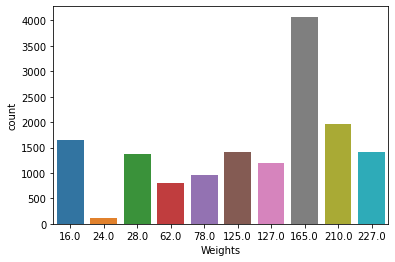

In [ ]:
sns.countplot(x='Weights', data=very_cleaned)

In [ ]:
balanced_df = very_cleaned.drop(very_cleaned[very_cleaned.Weights == 24.0].index)

In [ ]:
X = balanced_df.iloc[:,54]
y = np.array(balanced_df.Weights)



##Split strategies

###Posewise split

In [ ]:
import random

lens = []
test = []
train = []
count = 0
for object in tqdm(objects):
    object_df = experiments_df.loc[experiments_df['object'] == object]
    poses = object_df.pose.unique()
    random.shuffle(poses)
    if(len(poses) == 5):
      test_poses = poses[:1]
    elif(len(poses) == 4):
      test_poses = poses[:1]
    elif(len(poses) == 2):
      test_poses = poses[:1]
    for pose in poses:
        pose_df = object_df[object_df['pose'] == pose]
        if pose in test_poses:
          test.append(pose_df)
        else:
          train.append(pose_df)

experiment_test = pd.concat(test).drop_duplicates()
experiment_train = pd.concat(train).drop_duplicates()

  0%|          | 0/10 [00:00<?, ?it/s]

###Objectwise split

In [ ]:
weights = np.array(experiments_df.Weights.unique())
test_weights = weights[np.random.choice(len(weights), size=2, replace=False)]
experiment_test = experiments_df[np.isin(experiments_df['Weights'], test_weights)]
experiment_train = experiments_df[np.invert(np.isin(experiments_df['Weights'], test_weights))]
experiment_test = pd.concat(test).drop_duplicates()
experiment_train = pd.concat(train).drop_duplicates()

In [ ]:
experiment_train

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,12_t,13_t,14_t,15_t,16_t,17_t,object,pose,experiment,Weights
101990,-24.0,1.0,1.0,-11.0,-1.0,0.0,-76.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,SpoolSolder,Pose5,Exp10,28.0
101991,-24.0,1.0,1.0,-11.0,-1.0,0.0,-76.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,SpoolSolder,Pose5,Exp10,28.0
101992,-24.0,1.0,1.0,-11.0,-1.0,0.0,-76.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,SpoolSolder,Pose5,Exp10,28.0
101994,-24.0,1.0,1.0,-11.0,-1.0,0.0,-76.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,SpoolSolder,Pose5,Exp10,28.0
102003,-24.0,1.0,1.0,-11.0,-1.0,0.0,-76.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,SpoolSolder,Pose5,Exp10,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474006,0.0,0.0,-100.0,0.0,1.0,65.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,marker,Pose3,Exp8,62.0
1474026,0.0,0.0,-100.0,0.0,1.0,65.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,marker,Pose3,Exp8,62.0
1474031,0.0,0.0,-100.0,0.0,1.0,66.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,marker,Pose3,Exp8,62.0
1474034,0.0,0.0,-100.0,0.0,1.0,66.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,marker,Pose3,Exp8,62.0


###Random split

In [ ]:
# balanced_df = balanced_df.drop_duplicates()
# X = np.array(very_cleaned.iloc[:,:54])
# y = np.array(very_cleaned.Weights)

X = np.array(experiments_df.iloc[:,:54])
y = np.array(experiments_df.Weights)

# Scikit learn

In [ ]:
X_train, X_test = np.array(experiment_train.iloc[:,:18]), np.array(experiment_test.iloc[:,:18])
y_train, y_test = np.array(experiment_train.Weights), np.array(experiment_test.Weights)

NameError: ignored

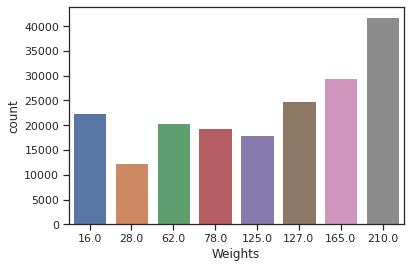

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from joblib import dump, load

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
def print_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'R² score: {r2} \t Mean Absolute Error: {mae} \t Mean Squared Error: {mse}')
    return mse,r2, mae

In [ ]:
count = 1

In [ ]:
model_name = 'GBR'
GBR = GradientBoostingRegressor()
parameters = {'learning_rate': [0.01,0.1],
                  'subsample'    : [0.9, 0.5, 0.1],
                  'n_estimators' : [50,100],
                 }

model_search = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 5, n_jobs=8, verbose=5)

In [ ]:
from sklearn.linear_model import LinearRegression
model_name = 'LR'
reg = LinearRegression()
parameters = {
              "fit_intercept": [True, False],
              'normalize': [True, False], 
             }
model_search = GridSearchCV(estimator=reg, param_grid = parameters, cv = 5, n_jobs=8, verbose=5)

In [ ]:
sample_1K = t_only.sample(n=1000)
X = sample_1K.iloc[:,:18]
y = np.array(sample_1K.Weights)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
# nm = Normalizer()

# X_train = nm.fit_transform(X_train)
# X_test = nm.transform (X_test)


model_search.fit(X_train, y_train)

best_model = model_search.best_estimator_

X = t_only.iloc[:,:18]
y = np.array(t_only.Weights)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
nm = Normalizer()

# X_train = nm.fit_transform(X_train)
# X_test = nm.transform (X_test)
best_model.fit(X_train, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(Standar

LinearRegression(normalize=True)

In [ ]:
final_mse,r2,mae = print_scores(best_model, X_test, y_test)
y_pred = best_model.predict(X_test)
result_df = pd.DataFrame(dict(Actual=y_test, Predicted=y_pred))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]
result_df

R² score: 0.37103052049480667 	 Mean Absolute Error: 44.00271133920099 	 Mean Squared Error: 3130.8184406787445


,object,Weights,Predicted
0,marbleNet,165.0,138.936618
1,marbleNet,165.0,151.038752
2,marbleNet,165.0,153.478359
3,marbleNet,165.0,131.556087
4,marbleNet,165.0,157.980925
...,...,...,...
5971,brush,24.0,114.064531
5972,brush,24.0,113.741991
5973,brush,24.0,150.854309
5974,brush,24.0,114.693899


In [ ]:
config ={}
config['raw_data'] = 'normal'
config['dataset'] = 't unbalanced no duplicated'
config['model'] =  model_name
config['split'] =  'random'
config['scaling'] = 'normal'

config = {**config, **best_model.get_params(deep=False)}


name = f'experiment_{count}'
wandb.init(project='MS_Thesis', config=config, group='FT random scikit', tags=['unbalanced', 'random', 'normal'], name=name)

wandb.log({"final_mse": final_mse})


model_path = f'/content/drive/MyDrive/MS_Project/Models/Scikit_learn/{model_name}.joblib'
dump(best_model, model_path)

artifact = wandb.Artifact(model_name, type='model', description='Final trained model')
artifact.add_file(model_path)
wandb.log_artifact(artifact)

import plotly.express as px
fig = px.box(result_df, x="Weights", y="Predicted", title=f'Weight estimation performance per weight - {name}',labels={'x': 'Actual Weights (g)', 'y':'Predicted Weights (g)'}, template='simple_white')
fig.show()
wandb.log({"Weightwise prediction": fig})
wandb.finish()
count = count + 1

final_mse,▁
final_mse,3130.81844


In [ ]:
y_pred = best_GBR.predict(X_test)
result_df = pd.DataFrame(dict(Actual=y_test, Predicted=y_pred))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]
result_df

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression
model_name = 'LR'
reg = LinearRegression()
parameters = {
              "fit_intercept": [True, False],
              'normalize': [True, False], 
             }

grid = GridSearchCV(estimator=reg, param_grid = parameters, cv = 5, n_jobs=6, verbose=3)    
grid.fit(X_train, y_train)
reg = grid.best_estimator_
reg.score(X_test,y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


0.5822868240342973

In [ ]:
print_scores(reg,X_test, y_test )

R² score: 0.9876337265071691 	 Mean Absolute Error: 5.567433640546711 	 Mean Squared Error: 61.70742453601584


In [ ]:
y_pred = reg.predict(X_test)
result_df = pd.DataFrame(dict(Actual=y_test, Predicted=y_pred))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]
result_df

In [ ]:
def run_parameter_search(model, parameters, x_test,y_test, x_train, y_train):
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=6, verbose=3)   
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    print(f'Best model: {best_model}')
    print_scores(best_model, x_test,y_test)
    return best_model

In [ ]:
from sklearn.linear_model import HuberRegressor

regressor = HuberRegressor(max_iter=10000)
parameters = {
              "epsilon": [1.10,1.20,1.30,1.40],
              'alpha': [0.0001,0.001,0.1], 
             }

run_parameter_search(regressor, parameters, X_test, y_test, X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   31.7s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:  1.3min finished


Best model: HuberRegressor(alpha=0.1, epsilon=1.3, max_iter=10000)
R² score: -0.06929708331110884 	 Mean Absolute Error: 61.51942366039883 	 Mean Squared Error: 5150.936509418976


HuberRegressor(alpha=0.1, epsilon=1.3, max_iter=10000)

# Keras

In [ ]:
#sample_100K = lift_only.sample(n=100000, random_state=25)

#sns.countplot(x='Weights', data=sample_100K)

###Training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

# change image from channels last to channels first format
from numpy import moveaxis

from sklearn.model_selection import train_test_split
from keras import backend as K
from tensorflow import keras
keras.backend.set_image_data_format('channels_first')
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Test train random split

In [ ]:
# X_train, X_test = np.array(experiment_train.iloc[:,:54]), np.array(experiment_test.iloc[:,:54])
# y_train, y_test = np.array(experiment_train.Weights), np.array(experiment_test.Weights)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Experiment based split

In [ ]:
config = {}
config['batch_size'] = 20000
config['epochs'] = 5000
config['raw_data'] = 'normal'
config['dataset'] = 'x y z unbalanced no duplicated'
config['split'] =  'random'
config['scaling'] = 'MinMax'

In [ ]:
nm = MinMaxScaler()

X_train = nm.fit_transform(X_train)
X_test = nm.transform (X_test)

X_train = X_train.reshape((X_train.shape[0]),6,3,3)
X_test = X_test.reshape((X_test.shape[0]),6,3,3)

batch_size = config['batch_size']
epochs =config['epochs']
# input image dimensions
img_rows, img_cols = 6, 3
X_train = moveaxis(X_train, 3, 1)
X_test = moveaxis(X_test, 3, 1)
input_shape = (3, img_rows, img_cols)

print(f'Test train ratio is: {len(X_train)/ (len(X_test) +len(X_train))}')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Test train ratio is: 0.7999979867933644
x_train shape: (158950, 3, 6, 3)
158950 train samples
39738 test samples


In [ ]:
!rm -rf ./content/drive/MyDrive/MS_Project/Log
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/MS_Project/Log2

In [ ]:
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import datetime, os

check_point_dir = '/content/drive/MyDrive/MS_Project/Models/UBal_pose_split_1/check_points/'

model_checkpoint_callback = ModelCheckpoint(
    filepath=check_point_dir,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logdir = os.path.join("/content/drive/MyDrive/MS_Project/Log2", f'No_dup_random_split_1_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)


# wandb.tensorboard.patch(root_logdir=logdir)

In [ ]:
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

def decay_schedule(epoch, lr):
    # decay by 0.1 every 5 epochs; use `% 1` to decay after each epoch
    if (epoch % 2000 == 0) and (epoch != 0) and (lr > 0.0001):
        lr = lr * 0.25
    return lr
lr_scheduler = LearningRateScheduler(decay_schedule)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, min_lr=0.000000001, cooldown=100)

In [ ]:
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.layers.merge import concatenate
from keras.layers import Input, LeakyReLU
from keras.models import Model


# # input layer
# visible = Input(shape=input_shape)

# #First feature extractor
# conv1 = Conv2D(256, (3,3), activation='relu',  padding='same')(visible)
# pool1 = MaxPooling2D(pool_size=(2, 2),  padding='same')(conv1)
# flat1 = Flatten()(pool1)

# #Second feature extractor
# conv2 = Conv2D(256, (6,6), activation='relu',  padding='same')(visible)
# pool2 = MaxPooling2D(pool_size=(2, 2),  padding='same')(conv1)
# flat2 = Flatten()(pool1)

# # merge feature extractors
# merge = concatenate([flat1, flat2])

# # interpretation layer
# hidden1 = Dense(128, activation='relu')(merge)
# hidden2 = Dense(64, activation='relu')(hidden1)
# # prediction output
# output = Dense(1, activation='linear')(hidden2)
# model = Model(inputs=visible, outputs=output)
# # summarize layers
# print(model.summary())
config['Learning rate'] = 0.00001
opt = keras.optimizers.Adam(learning_rate=config['Learning rate'] )
#opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True, name="SGD")
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape = input_shape))
model.add(Conv2D(128, (1, 1), activation='tanh', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),  padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),  padding='same'))


# model.add(Conv2D(256, (6, 1), activation='relu', padding='same'))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(258, activation='relu'))



model.add(Dense(1, activation='linear'))




model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as  mean_squared_error
                  optimizer=opt,
                  metrics=[r2_keras, mean_absolute_error] # you can add several if needed
                 )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 4, 1)          1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 4, 1)         8320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 2, 1)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 2, 1)         147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 1, 1)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0

In [ ]:
count = 21

In [ ]:
config['model'] =  '3 layer CNN'
config['loss'] = 'mean_squared_error'

config['optimizer'] = 'adam'
config['Reduce LR on Plateau'] = False

from wandb.keras import WandbCallback

name = f'experiment_{count}'

wandb.init(project='MS_Thesis', config=config, group='random report', tags=['unbalanced', 'random', 'Normal', 'xyz', 'report'], name=name)
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback, model_checkpoint_callback, WandbCallback(save_model=False, save_graph=True), 
                     keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0.1,patience=100,verbose=0,mode="auto",baseline=None,restore_best_weights=True,)])

wandb: Currently logged in as: arunbaby. Use `wandb login --relogin` to force relogin


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/5000
6/8 [=====================>........] - ETA: 0s - loss: 19805.1738 - r2_keras: -3.1127 - mean_absolute_error: 122.4286

Streaming output truncated to the last 5000 lines.
8/8 [==============================] - 1s 65ms/step - loss: 436.9947 - r2_keras: 0.9092 - mean_absolute_error: 12.4496 - val_loss: 408.7339 - val_r2_keras: 0.9148 - val_mean_absolute_error: 11.0302
Epoch 2502/5000
8/8 [==============================] - 1s 93ms/step - loss: 435.8016 - r2_keras: 0.9095 - mean_absolute_error: 12.4474 - val_loss: 408.5905 - val_r2_keras: 0.9149 - val_mean_absolute_error: 11.0308
Epoch 2503/5000
8/8 [==============================] - 1s 89ms/step - loss: 436.5826 - r2_keras: 0.9093 - mean_absolute_error: 12.4488 - val_loss: 408.0010 - val_r2_keras: 0.9150 - val_mean_absolute_error: 11.0119
Epoch 2504/5000
8/8 [==============================] - 1s 94ms/step - loss: 434.8248 - r2_keras: 0.9097 - mean_absolute_error: 12.4379 - val_loss: 407.5721 - val_r2_keras: 0.9151 - val_mean_absolute_error: 10.9918
Epoch 2505/5000
8/8 [==============================] - 1s 94ms/step - loss: 435.3590 - r2_keras: 0.9096 - mea

In [ ]:
final_mse,_,_ = model.evaluate(X_test, y_test, verbose=3)
wandb.log({"final_mse": final_mse, "experiment": name})
final_mse

5.870743751525879

In [ ]:
trained_model_dir = f'/content/drive/MyDrive/MS_Project/Models/Bal_rand_Split/{name}/'
model.save(trained_model_dir)
artifact = wandb.Artifact('2_layer_CNN', type='model', description='Final trained model')
artifact.add_dir(trained_model_dir)
wandb.log_artifact(artifact)


y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred.flatten())

result_df = pd.DataFrame(dict(Actual=np.array(y_test), Predicted=y_pred))
result_df = result_df.merge(weight_df, left_on='Actual', right_on='Weights')
result_df = result_df.loc[:, ('object', 'Weights', 'Predicted')]
#result_df.to_excel('/content/drive/MyDrive/MS_Project/Split_objects_CNN_result_final.xlsx')


import plotly.express as px
fig = px.box(result_df, x="Weights", y="Predicted", title=f'Weight estimation performance per weight {name}',labels={'x': 'Actual Weights (g)', 'y':'Predicted Weights (g)'}, template='simple_white')
fig.show()
wandb.log({"Weightwise prediction": fig})
wandb.finish()
count = count + 1

wandb: Adding directory to artifact (/content/drive/MyDrive/MS_Project/Models/Bal_rand_Split/experiment_19)... Done. 0.1s


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_mse,▁
loss,█▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r2_keras,▁▃▅▆▆▇▇█████████████████████████████████
val_loss,█▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_r2_keras,▁▃▅▆▆▇▇█████████████████████████████████
GFLOPs,0.0002
best_epoch,4347
best_val_loss,5.77707


In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

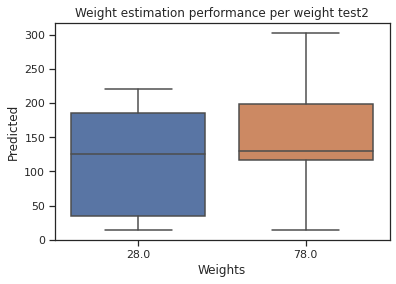

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:649: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



In [ ]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots()
#plt.figure(figsize=(18,10))
# Draw a nested boxplot to show bills by day and time
plot = sns.boxplot(x="Weights", y="Predicted",
            data=result_df, ax = ax)
plot.set_xlabel("Weights")
plot.set_ylabel("Predicted")
plot.set_title(f'Weight estimation performance per weight {name}')
plot.tick_params()

plt.show()
wandb.log({"Weightwise prediction": fig})


wandb.finish()

In [ ]:
plt.show()

In [ ]:
!tensorboard dev upload --logdir /content/drive/MyDrive/MS_Project/Log --name "CNN only v2 final" --description "Weight estimation using uSkin sensor data with just lift phase" 

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/6uqTRNI2Sr6yCzwH7bZ56g/

[2022-08-12T00:18:19] Started scanning logdir.
[2022-08-12T00:18:21] Total uploaded: 0 scalars, 692 tensors (497.4 kB), 1 binary objects (47.9 kB)
Listening for new data in logdir...

Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/6uqTRNI2Sr6yCzwH7bZ56g/


In [ ]:
!pip install keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras_visualizer import visualizer 

In [ ]:
from keras.utils.vis_utils import plot_model

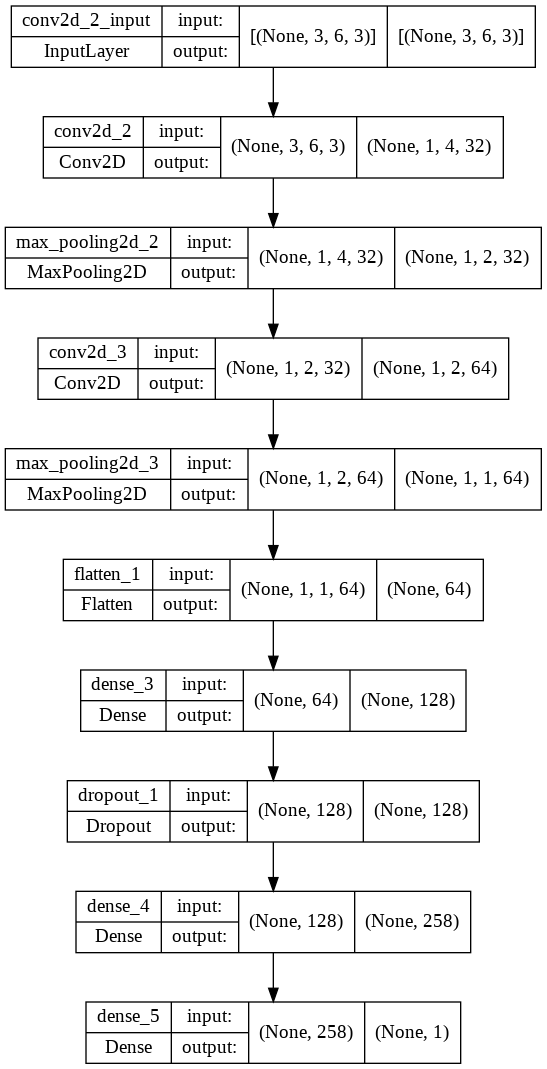

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 4.1 MB/s 


In [ ]:
import visualkeras
from PIL import ImageFont

In [ ]:
visualkeras.layered_view(model) 

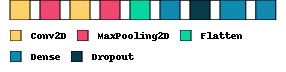

In [ ]:
from PIL import ImageFont
visualkeras.layered_view(model, legend=True, draw_volume=False) 

In [ ]:
pip install netron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.2 MB/s 


In [ ]:
!pip install ann_visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=deba1ffdd654c90d7a1cee7e7bb0505adb4a7325319e775b58f8e1daf00d481e
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


In [ ]:
from ann_visualizer.visualize import ann_viz
ann_viz(model)


ValueError: ignored